# Mukh O Mukhosh, the face mask detector

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os

## read dataset 

In [2]:
root_path = "./data"

In [3]:
train_data_path = os.path.join(root_path, "train")
val_data_path = os.path.join(root_path, "val")

In [4]:
print(train_data_path)
print(val_data_path)

./data/train
./data/val


In [5]:
img_dim = 330
transform = transforms.Compose([
    transforms.RandomResizedCrop(img_dim),
    transforms.ToTensor()
])

In [6]:
train_data = datasets.ImageFolder(train_data_path, transform)
val_data = datasets.ImageFolder(val_data_path, transform)

In [7]:
print(train_data)
print(val_data)

Dataset ImageFolder
    Number of datapoints: 1314
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(330, 330), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 142
    Root location: ./data/val
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(330, 330), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [8]:
train_data.classes

['with_mask', 'without_mask']

In [9]:
train_data.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [10]:
train_data.imgs

[('./data/train/with_mask/-110603108-gettyimages-533567012.jpg', 0),
 ('./data/train/with_mask/-110695084-mask2.jpg', 0),
 ('./data/train/with_mask/0-with-mask.jpg', 0),
 ('./data/train/with_mask/0000305-62360-halyard-health-pfr-p3-respirator-face-mask-ffp.jpeg',
  0),
 ('./data/train/with_mask/0000444-48296-halyard-health-surgical-mask-teddy-bear-print.jpeg',
  0),
 ('./data/train/with_mask/007563.jpg', 0),
 ('./data/train/with_mask/0779db20580fc7b054ad6b1b7bd9fb35.jpeg', 0),
 ('./data/train/with_mask/1-respirator-mask.jpg', 0),
 ('./data/train/with_mask/10-with-mask.jpg', 0),
 ('./data/train/with_mask/100-with-mask.jpg', 0),
 ('./data/train/with_mask/101-with-mask.jpg', 0),
 ('./data/train/with_mask/103-with-mask.jpg', 0),
 ('./data/train/with_mask/104-with-mask.jpg', 0),
 ('./data/train/with_mask/105-with-mask.jpg', 0),
 ('./data/train/with_mask/106.jpg', 0),
 ('./data/train/with_mask/107-with-mask.jpg', 0),
 ('./data/train/with_mask/108-with-mask.jpg', 0),
 ('./data/train/with_mask

## train data analysis using Pandas

In [11]:
df = pd.DataFrame(train_data.imgs)

In [12]:
df.head()

,0,1
0,./data/train/with_mask/-110603108-gettyimages-...,0
1,./data/train/with_mask/-110695084-mask2.jpg,0
2,./data/train/with_mask/0-with-mask.jpg,0
3,./data/train/with_mask/0000305-62360-halyard-h...,0
4,./data/train/with_mask/0000444-48296-halyard-h...,0


In [13]:
df[0].describe()

count                                                  1314
unique                                                 1314
top       ./data/train/without_mask/augmented_image_113.jpg
freq                                                      1
Name: 0, dtype: object

In [14]:
def image_size(img):
    with Image.open(img) as im:
        return im.size

img_sizes = [image_size(img[0]) for img in train_data.imgs]

In [15]:
df_image_sizes = pd.DataFrame(img_sizes)

In [16]:
df_image_sizes

,0,1
0,410,230
1,976,549
2,525,350
3,320,320
4,1500,1500
...,...,...
1309,2448,3264
1310,550,750
1311,970,1200
1312,600,450


In [17]:
df_image_sizes[0].describe()

count    1314.000000
mean      397.927702
std       326.431366
min       110.000000
25%       260.000000
50%       320.000000
75%       349.750000
max      3456.000000
Name: 0, dtype: float64

## data loading

In [18]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=142, shuffle=True)

## convolutional model

In [19]:
in_channels = 3
num_filters = [6,16]
filter_dim = 3
stride = 1

x = int((((img_dim - 2)/2) - 2)/2)
fc1_in_features = x*x*num_filters[1]
#fc1_in_features = 61*61*16
fc1_out_features = 120
fc2_out_features = 84
out_features = 2

class FaceMaskDetectorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_filters[0], filter_dim, stride)
        #self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], filter_dim, stride)
        #self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(fc1_in_features, fc1_out_features)
        #self.fc1 = nn.Linear(61*61*16, 120)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(fc2_out_features,out_features)
        #self.fc3 = nn.Linear(84,2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, fc1_in_features)
        #X = X.view(-1, 61*61*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [20]:
torch.manual_seed(42)
model = FaceMaskDetectorModel()
model

FaceMaskDetectorModel(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=104976, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## loss function & optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## training

In [22]:
'''for b, (x_train, y_train) in enumerate(train_loader):
    print("b", b)
    print("x_train", x_train.shape)
    print("y_train", y_train.shape)
    break'''

'for b, (x_train, y_train) in enumerate(train_loader):\n    print("b", b)\n    print("x_train", x_train.shape)\n    print("y_train", y_train.shape)\n    break'

In [23]:
import time
start_time = time.time()

epochs = 45
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in range(epochs):
    trn_total = 0
    trn_corr = 0
    val_total = 0
    val_corr = 0
    
    print("------------------------epoch {epoch}-------------------------".format(epoch = i))
    
    # training batches
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        
        # prediction & loss calculation
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
 
        # prediction accuracy calculation
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += float(batch_corr)
        trn_total += float(x_train.shape[0])
        acc = (trn_corr * 100)/trn_total
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print after each epoch
        if(b%22 == 0):
            print("train --> batch: {batch}[{train_so_far}/{train_total_size}], loss: {ls}, accuracy: {accuracy}".format(batch = b, train_so_far = int(trn_total), train_total_size = len(train_data.imgs), ls = loss.item(), accuracy = acc))
    
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # validation batches
    with torch.no_grad():
        for b, (x_val, y_val) in enumerate(val_loader):
            b+=1
            # prediction & loss calculation
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)

            # prediction accuracy calculation
            predicted = torch.max(y_pred.data, 1)[1] 
            batch_corr = (predicted == y_val).sum()
            val_corr += float(batch_corr)
            val_total += float(x_val.shape[0])
            acc = (val_corr * 100)/val_total
            # print after each epoch
            print("valid --> batch: {batch}[{val_so_far}/{val_total_size}], loss: {ls}, accuracy: {accuracy}".format(batch = b, val_so_far = int(val_total), val_total_size = len(val_data.imgs), ls = loss.item(), accuracy = acc))
    
    val_losses.append(loss)
    val_accuracies.append(acc)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

------------------------epoch 0-------------------------
train --> batch: 22[220/1314], loss: 0.6343001127243042, accuracy: 58.63636363636363
train --> batch: 44[440/1314], loss: 0.32520541548728943, accuracy: 67.04545454545455
train --> batch: 66[660/1314], loss: 0.4757199287414551, accuracy: 71.21212121212122
train --> batch: 88[880/1314], loss: 0.4107549786567688, accuracy: 73.18181818181819
train --> batch: 110[1100/1314], loss: 0.4828628897666931, accuracy: 75.36363636363636
train --> batch: 132[1314/1314], loss: 0.1480584740638733, accuracy: 76.63622526636225
valid --> batch: 1[142/142], loss: 0.4008212089538574, accuracy: 84.50704225352112
------------------------epoch 1-------------------------
train --> batch: 22[220/1314], loss: 0.5245479345321655, accuracy: 83.63636363636364
train --> batch: 44[440/1314], loss: 0.4348432123661041, accuracy: 85.0
train --> batch: 66[660/1314], loss: 0.3849165439605713, accuracy: 85.60606060606061
train --> batch: 88[880/1314], loss: 0.1868805

train --> batch: 110[1100/1314], loss: 0.39053091406822205, accuracy: 90.18181818181819
train --> batch: 132[1314/1314], loss: 0.4064549207687378, accuracy: 90.18264840182648
valid --> batch: 1[142/142], loss: 0.17082998156547546, accuracy: 90.84507042253522
------------------------epoch 13-------------------------
train --> batch: 22[220/1314], loss: 0.7823623418807983, accuracy: 88.63636363636364
train --> batch: 44[440/1314], loss: 0.4443526268005371, accuracy: 89.77272727272727
train --> batch: 66[660/1314], loss: 0.2500106990337372, accuracy: 91.06060606060606
train --> batch: 88[880/1314], loss: 0.3951626420021057, accuracy: 91.13636363636364
train --> batch: 110[1100/1314], loss: 0.044086821377277374, accuracy: 91.72727272727273
train --> batch: 132[1314/1314], loss: 0.2785610556602478, accuracy: 91.47640791476408
valid --> batch: 1[142/142], loss: 0.16006341576576233, accuracy: 95.07042253521126
------------------------epoch 14-------------------------
train --> batch: 22[220/1

train --> batch: 44[440/1314], loss: 0.2034526765346527, accuracy: 93.63636363636364
train --> batch: 66[660/1314], loss: 0.17300449311733246, accuracy: 92.27272727272727
train --> batch: 88[880/1314], loss: 0.16549213230609894, accuracy: 91.70454545454545
train --> batch: 110[1100/1314], loss: 0.3249531090259552, accuracy: 91.36363636363636
train --> batch: 132[1314/1314], loss: 0.1912255734205246, accuracy: 91.17199391171994
valid --> batch: 1[142/142], loss: 0.19178824126720428, accuracy: 90.14084507042253
------------------------epoch 26-------------------------
train --> batch: 22[220/1314], loss: 0.1311693638563156, accuracy: 92.27272727272727
train --> batch: 44[440/1314], loss: 0.33060845732688904, accuracy: 93.18181818181819
train --> batch: 66[660/1314], loss: 0.23020179569721222, accuracy: 92.87878787878788
train --> batch: 88[880/1314], loss: 0.3480306565761566, accuracy: 92.95454545454545
train --> batch: 110[1100/1314], loss: 0.05026828497648239, accuracy: 92.181818181818

## loss and accuracy comparisons

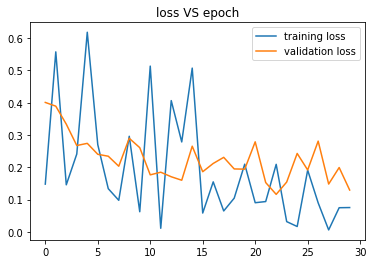

In [24]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('loss VS epoch')
plt.legend();

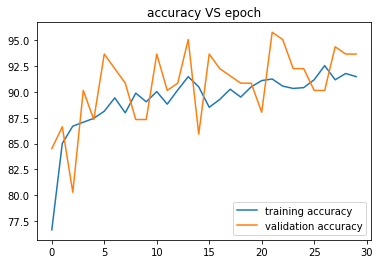

In [25]:
plt.plot(train_accuracies, label='training accuracy')
plt.plot(val_accuracies, label='validation accuracy')
plt.title('accuracy VS epoch')
plt.legend();